In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, NumbaPerformanceWarning
import cv2
import os
from numba.typed import List

from plot_helpers import plotCoordinateFrame, set_axes_equal
from jacobian import jac
from manifold import K_from_vec, vec_from_K, SE3_from_vec, vec_from_SE3, skew
from optimize import levenberg_marquardt

import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.set_printoptions(suppress=True, precision=3, edgeitems=30, linewidth=100000)

In [2]:
#----------- Projection helpers ----------#
@njit
def h(K, T, P):
    p_homo = K@T@to_homogen(P).T
    return from_homogen(p_homo.T)

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def residuals(K, Ts, Ps, zs):     
    # Compute expected measurements
    steps = [0] + [cam_meas[0].shape[0] for cam_meas in zs]
    steps = np.cumsum(np.array(steps))
    res = np.zeros(2*steps[-1])

    for cam_idx, (pt_idx, meas) in enumerate(zs):
        p_prime = h(K, Ts[cam_idx], Ps[pt_idx])
        res[2*steps[cam_idx]:2*steps[cam_idx+1]] = (meas - p_prime).flatten()
    
    return res

### Match points

In [5]:
# There was a bunch of bugs in the original implementation...
def plotMatches(im1, im2, locs1, locs2, filename=None):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    
    if len(im1.shape) >= 3:
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    if len(im2.shape) >= 3:
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2
    
    plt.imshow(im, cmap='gray')
    for ((x1, y1), (x2, y2)) in zip(locs1, locs2):
        plt.plot([x1, x2+im1.shape[1]], [y1,y2], 'r', lw=0.5)

    plt.show()
    
def sevenpoint(pts1, pts2, M):
    '''
    Q1.2: Seven Point Algorithm for calculating the fundamental matrix
        Input:  pts1, 7x2 Matrix containing the corresponding points from image1
                pts2, 7x2 Matrix containing the corresponding points from image2
                M, a scalar parameter computed as max (imwidth, imheight)
        Output: Farray, a list of estimated 3x3 fundamental matrixes.
    '''
    Farray = []

    # Computing the 3x3 matrix used to normalize corresponding points. 
    T = np.diag([1/M,1/M,1])
    
    # Scale our points
    pts1 = pts1@T[:2,:2]
    pts2 = pts2@T[:2,:2]
    x1, y1 = pts1.T
    x2, y2 = pts2.T
    ones = np.ones_like(x2)
    
    # Create our matrices
    A = np.column_stack((x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, ones))
    
    # Use SVD to extract F
    U, S, VT = np.linalg.svd(A)
    Fs = np.array([VT[-1].reshape((3,3)).T, VT[-2].reshape((3,3)).T])
    
    # Solve cubic
    D = np.zeros((2,2,2))
    for i1 in range(2):
        for i2 in range(2):
            for i3 in range(2):
                temp = np.zeros((3,3))
                temp[:,0] = Fs[i1,0]
                temp[:,1] = Fs[i2,1]
                temp[:,2] = Fs[i3,2]
                D[i1,i2,i3] = np.linalg.det(temp)
                
    coeff = np.zeros(4)
    coeff[0] = -D[1][0][0]+D[0][1][1]+D[0][0][0]+D[1][1][0]+D[1][0][1]-D[0][1][0]-D[0][0][1]-D[1][1][1];
    coeff[1] = D[0][0][1]-2*D[0][1][1]-2*D[1][0][1]+D[1][0][0]-2*D[1][1][0]+D[0][1][0]+3*D[1][1][1];
    coeff[2] = D[1][1][0]+D[0][1][1]+D[1][0][1]-3*D[1][1][1];
    coeff[3] = D[1][1][1];

    roots = np.polynomial.polynomial.polyroots(coeff[::-1])
    for r in roots:
        if np.isreal(r):
            a = np.real(r)
            F = Fs[0]*a + (1-a)*Fs[1]
            # Clean up matrix
            F = T.T@F@T
            F = F/F[2,2]
            Farray.append( F )
    
    return Farray    

def calc_epi_error(pts1_homo, pts2_homo, F):
    '''
    Helper function to calculate the sum of squared distance between the corresponding points and the estimated epipolar lines. 
    Expect pts1 and pts2 are in homogeneous coordinates and not normalized. 
    '''
    line1s = pts1_homo.dot(F.T)
    dist1 = np.square(np.divide(np.sum(np.multiply(
        line1s, pts2_homo), axis=1), np.linalg.norm(line1s[:, :2], axis=1)))

    line2s = pts2_homo.dot(F)
    dist2 = np.square(np.divide(np.sum(np.multiply(
        line2s, pts1_homo), axis=1), np.linalg.norm(line2s[:, :2], axis=1)))

    ress = (dist1 + dist2).flatten()
    return ress

def ransacF(pts1, pts2, M, max_iter=1000, tol=2):
    '''
    Q3.1: RANSAC method.
        Input:  pts1, Nx2 Matrix
                pts2, Nx2 Matrix
                M, a scaler parameter
        Output: F, the fundamental matrix
                inlier_curr, Nx1 bool vector set to true for inliers
    '''
    N = pts1.shape[0]
    pts1_homo, pts2_homo = to_homogen(pts1), to_homogen(pts2)
    inlier_curr = np.zeros(pts1.shape[0])
    
    # ----- TODO -----
    for i in range(max_iter):
        # Find H from random sample
        idx = np.random.randint(0, N, 7)
        Fs = sevenpoint(pts1[idx], pts2[idx], M)
        
        for F_prop in Fs:
            err = calc_epi_error(pts1_homo, pts2_homo, F_prop)
            inl = err < tol
            if np.sum(inl) > np.sum(inlier_curr):
                inlier_curr = inl
                F = F_prop
                
    return F, inlier_curr

def poses_from_E(E):
    # Decompose to find pose options
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    # Make sure we have the right size
    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    # Make all possible options
    M2s = np.zeros([3,4,4])
    M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    return M2s

def E_from_FK(F, K):
     # First find the essential matrix
    E = K.T@F@K
    
    # Enforce rank 2
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    
    return E

def triangulate(C1, pts1, C2, pts2):
    '''
    Q2.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
        Input:  C1, the 3x4 camera matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                C2, the 3x4 camera matrix
                pts2, the Nx2 matrix with the 2D image coordinates per row
        Output: P, the Nx3 matrix with the corresponding 3D points per row
                err, the reprojection error.
    
    ***
    Hints:
    (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
    (2) Solve for the least square solution using np.linalg.svd
    (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from 
        homogeneous coordinates to non-homogeneous ones)
    (4) Keep track of the 3D points and projection error, and continue to next point 
    (5) You do not need to follow the exact procedure above. 
    '''
    # ----- TODO -----
    p11, p12, p13 = C1
    p21, p22, p23 = C2
    N = pts1.shape[0]
    
    err = 0
    Pest = np.zeros((N,3))
    for i, ((x1, y1), (x2,y2)) in enumerate(zip(pts1, pts2)):
        # Get homogenous point
        A = np.vstack((
                        y1*p13 -    p12, 
                           p11 - x1*p13,
                        y2*p23 -    p22,
                           p21 - x2*p23
                ))
        
        U, S, VT = np.linalg.svd(A)
        Pi = VT[-1]
        Pi /= Pi[-1]
        
        # Compute reprojection err
        reproj_1 = C1@Pi
        reproj_2 = C2@Pi
        reproj_1 /= reproj_1[-1]
        reproj_2 /= reproj_2[-1]

        err += np.sum( (reproj_1[:2] - [x1,y1])**2 ) + np.sum( (reproj_2[:2] - [x2,y2])**2 ) #+ np.linalg.norm(X)/10
        Pest[i] = Pi[:3]
        
    return Pest, err
    

def pose_from_E(E, pts1, pts2, K):
    '''
    Q2.2: Function to find the camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)
    '''

    M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
    C1 = K@M1
    M2s = poses_from_E(E)
    best_error = np.finfo('float').max
    
    # Find which M is best
    for i in range(M2s.shape[-1]):
        Mi = M2s[:,:,i]
        Ci = K@Mi
        Pi, err = triangulate(C1, pts1, Ci, pts2)
        
        if err < best_error and np.all(Pi[:,2] >= 0):
            best_error = err
            M2best = Mi
            C2best = Ci
            P_best = Pi
            
    M2best = np.vstack((M2best, [[0,0,0,1]]))
    
    # print(f"Best Error {best_error}")
    return M2best, P_best

def find_kp(im):
    # Initiate SIFT detector
    feat = cv2.SIFT_create()
    # feat = cv2.ORB_create()
    
    # find the keypoints and descriptors with SIFT
    kp, des = feat.detectAndCompute(im,None)
    kp = np.array([k.pt for k in kp])
    return kp, des

In [75]:
K_init

array([[525. ,   0. , 319.5,   0. ],
       [  0. , 525. , 239.5,   0. ],
       [  0. ,   0. ,   1. ,   0. ]])

In [74]:
%matplotlib inline 

K_init = K_from_vec( np.array([525, 525, 319.5, 239.5]) )

folder = "data/chair"
valid_imgs = [".jpg", ".png"]
images = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if os.path.splitext(f)[1].lower() in valid_imgs][:40:5]

# Take this out later, only try on some images so far
images = images[0:2]
print(images)

# Get started with first image
im1 = cv2.imread(images[0])
kp1, des1 = find_kp(im1)

Ts_init = np.zeros((len(images), 4, 4))
Ts_init[0] = np.eye(4)
Ps_init = []
Ps_color = []
last_iter_matches = {}
zs = [[] for _ in images]
lm_num = 0

# Iterate through all images
for i, file in enumerate(images[1:]):
    im2 = cv2.imread(file)
    kp2, des2 = find_kp(im2)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    good_match = []
    knn_matches = bf.knnMatch(des1, des2, k=2)

    # Ratio test
    matches = []
    for m,n in knn_matches:
        if m.distance < 0.5*n.distance:
            matches.append([m.queryIdx, m.trainIdx])
    matches = np.array(matches)
    kp1_match = kp1[matches[:,0]]
    kp2_match = kp2[matches[:,1]]
    print("Number Matches ", kp1_match.shape)
    
    # TODO: Something is up with my estimation here... kept choosing wrong option
    # Also, my RANSAC is REALLY slow
    # Estimate F and apply ransac
    F, inlier = ransacF(kp1_match, kp2_match, np.max(im2.shape), max_iter=10000)
    kp1_match = kp1_match[inlier]
    kp2_match = kp2_match[inlier]
    matches = matches[inlier]
    E = E_from_FK(F, K_init[:3,:3])
    
    # E, inlier = cv2.findEssentialMat(kp1_match, kp2_match, K_init[:3,:3], method=cv2.RANSAC, threshold=1.5, prob=0.99)
    # inlier = inlier.flatten().astype('bool')
    # kp1_match = kp1_match[inlier]
    # kp2_match = kp2_match[inlier]
    # matches = matches[inlier]  
    # plotMatches(im1, im2, kp1_match, kp2_match)
    

    # Calculate Pose from essential matrix - used for initialization
    # Gives relative pose of frame i+1 wrt frame i
    T, Ps = pose_from_E(E, kp1_match, kp2_match, K_init[:3,:3])
    print(T)
    print(E)
    
#     points, R, t, inlier = cv2.recoverPose(E, kp1_match, kp2_match, K_init[:3,:3])
#     print(points, np.sum(inlier != 0))
#     T = np.eye(4)
#     T[:3,:3] = R
#     T[:3,3] = t.flatten()
    
#     Ps = cv2.triangulatePoints(K_init, K_init@T, kp1_match.T, kp2_match.T).T
#     Ps = from_homogen(Ps)
    # Ps, err = triangulate(K_init, kp1_match, K_init@T, kp2_match)
    print(np.sum(Ps[:,2] >= 0))
    
    # Transform into global coordinates
    Ts_init[i+1] = Ts_init[i]@T
    Ps = from_homogen( (Ts_init[i]@to_homogen(Ps).T).T )
    
    # Check if a landmark has already been seen before
    iter_matches = {}
    for (idx1, idx2), k_1, k_2, P in zip(matches, kp1_match, kp2_match, Ps):
        if idx1 in last_iter_matches:
            l = last_iter_matches[idx1]
            Ps_color[l].extend( [im1[int(k_1[1]), int(k_1[0])], im2[int(k_2[1]), int(k_2[0])]] )
        else: 
            Ps_init.append( P )
            Ps_color.append( [im1[int(k_1[1]), int(k_1[0])], im2[int(k_2[1]), int(k_2[0])]] )
            l = lm_num
            lm_num += 1
            
        # Save measurment for later
        # Index zs with cam idx, then insert point idx, pixel values
        zs[ i ].append((l, *k_1))
        zs[i+1].append((l, *k_2))
        iter_matches[idx2] = l
                
    # Prep for next iteration
    kp1 = kp2
    des1 = des2
    im1 = im2
    last_iter_matches = iter_matches

zs = [np.array(meas) for meas in zs]
zs = List((meas[:,0].astype('int'), meas[:,1:3]) for meas in zs)
Ps_init = np.array(Ps_init)
Ps_color = np.array([np.mean(m, axis=0).astype('uint8') for m in Ps_color]) / 255
Ps_color[:,[0,2]] = Ps_color[:,[2,0]]
# plotMatches(im1, im2, kp1, kp2)

['data/chair/0000001-000000000000.jpg', 'data/chair/0000006-000000167580.jpg']
Number Matches  (392, 2)
[[-0.673 -0.144  0.726 -0.448]
 [-0.139 -0.939 -0.315  0.196]
 [ 0.727 -0.313  0.611 -1.   ]
 [ 0.     0.     0.     1.   ]]
[[   0.528 -158.184  -30.882]
 [ 157.892    0.589  -71.47 ]
 [  30.714   71.001   -0.171]]
392


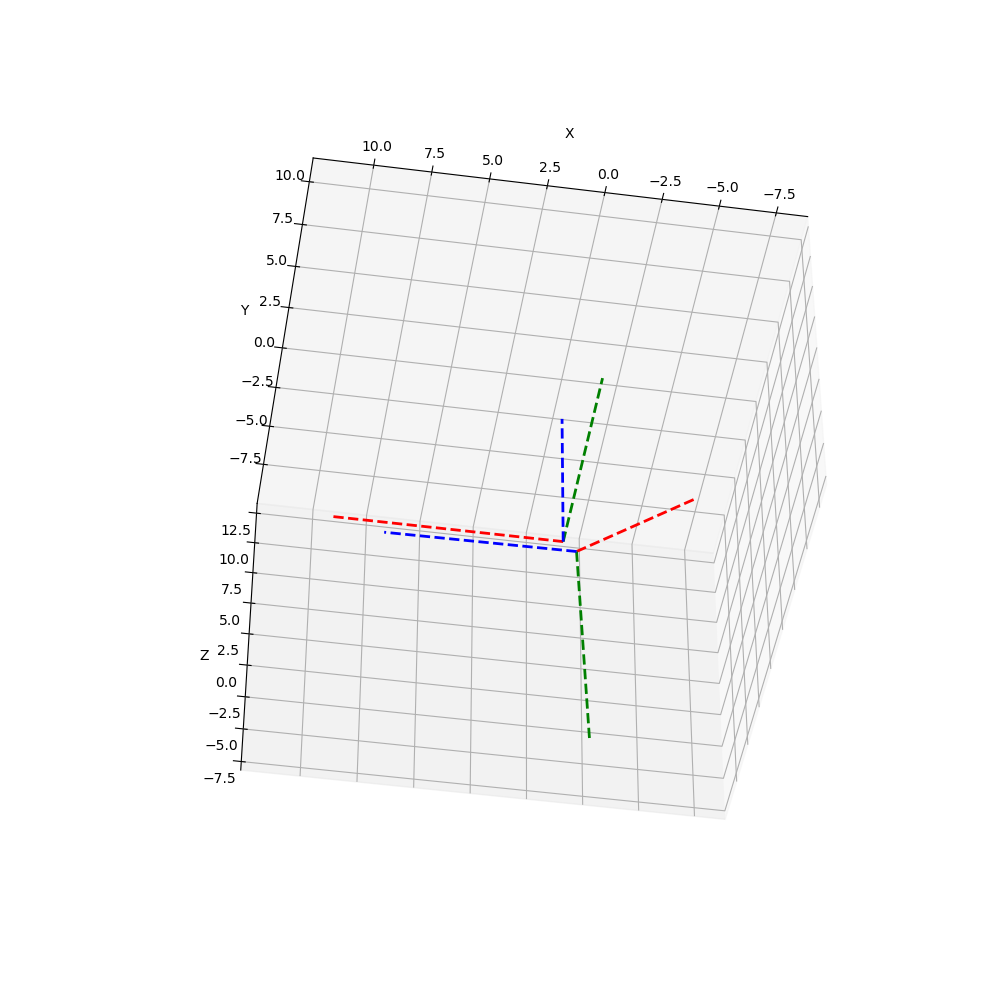

In [73]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(Ps_init[:,0], Ps_init[:,1], Ps_init[:,2], s=1)
for T in Ts_init:
    plotCoordinateFrame(T, ax=ax, k="--", size=10)

# for gt in Ts_gt:
#     plotCoordinateFrame(gt, ax=ax, size=.01)

set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-44, 81)
plt.show()

### Run Optimizer

In [7]:
print(np.linalg.norm(residuals(K_init, Ts_init, Ps_init, zs))**2)
K_result, Ts_result, Ps_result = levenberg_marquardt(residuals, K_init, Ts_init, Ps_init, zs, jac, max_iters=100, lam=.001, lam_multiplier=2, tol=1e-4, verbose=True)
print(np.linalg.norm(residuals(K_result, Ts_result, Ps_result, zs))**2)

1980558897.9358187
Starting cost: 1980558897.9358184
0, 	 Cost: 402062314.73085725 	 Lam: 0.001
1, 	 Cost: 357989682.1398867 	 Lam: 0.001
2, 	 Cost: 45888672.856781185 	 Lam: 0.001
3, 	 Cost: 3288012.7459470825 	 Lam: 0.001
4, 	 Cost: 3226651.185428755 	 Lam: 524.288
5, 	 Cost: 2026786.343374616 	 Lam: 8388.608
6, 	 Cost: 1339795.4074391592 	 Lam: 536870.912
7, 	 Cost: 123864.40397132076 	 Lam: 268435.456
8, 	 Cost: 54203.43382660903 	 Lam: 134217.728
9, 	 Cost: 26403.860572438014 	 Lam: 67108.864
10, 	 Cost: 12898.114233951612 	 Lam: 33554.432
11, 	 Cost: 7767.5526465055755 	 Lam: 16777.216
12, 	 Cost: 6546.509462824481 	 Lam: 8388.608
13, 	 Cost: 4873.641625071305 	 Lam: 8388.608
14, 	 Cost: 4319.392982062163 	 Lam: 8388.608
15, 	 Cost: 4130.363819899512 	 Lam: 8388.608
16, 	 Cost: 4033.236804992763 	 Lam: 8388.608
17, 	 Cost: 3971.5888418747268 	 Lam: 8388.608
18, 	 Cost: 3927.1005223055845 	 Lam: 8388.608
19, 	 Cost: 3892.498393528519 	 Lam: 8388.608
20, 	 Cost: 3864.443083971809 	

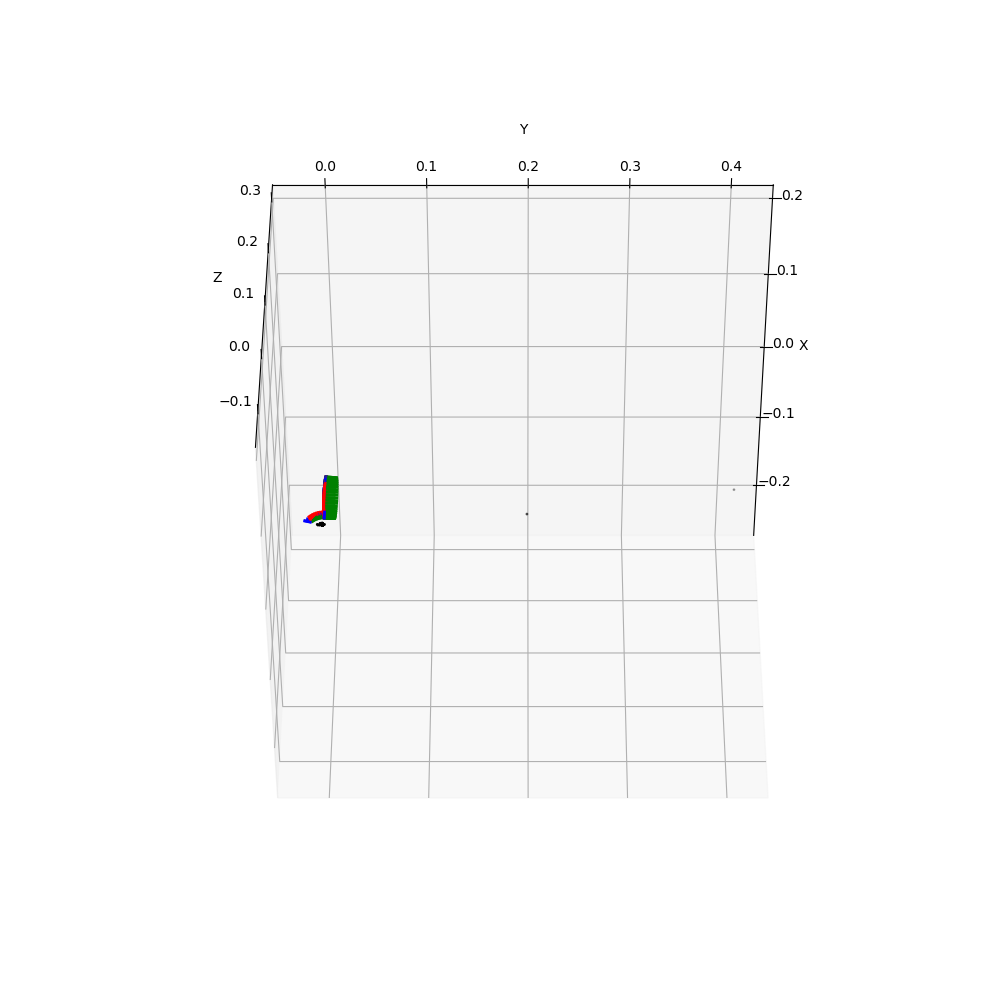

In [8]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Ps_result[:,0], Ps_result[:,1], Ps_result[:,2], s=1, c=Ps_color/255)
for T, gt in zip(Ts_result, Ts_gt):
    plotCoordinateFrame(gt, ax=ax, size=.01)
    plotCoordinateFrame(T, ax=ax, k="--", size=0.01)
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, 0)
plt.show()